# Routing network traffic based on firewall logs using Machine Learning

## Problem Statement:

The firewall system plays a vital role in network security by regulating network traffic through security rules. Setting up and maintaining the firewall system is a complex task, prone to human error and requiring regular modification to remain compliant with security policy. The proper routing of traffic ensures compliance with security policy and prevents unauthorized access to prohibited websites. Machine learning models can aid in the proper maintenance of firewall systems by analyzing historical data from firewall log reports, thus reducing the likelihood of errors and ensuring stable internet traffic.
###### The aim of this case study is to explore the use of machine learning models for firewall maintenance and to demonstrate their effectiveness in identifying and blocking prohibited websites on a network.

# Data Understanding:

### Data Source: https://archive.ics.uci.edu/ml/datasets/Internet+Firewall+Data

The dataset used in this case study is compiled by Fatih Ertam at Firat University, Turkey. The dataset contains 65532 instances with 12 features collected by logs of the university firewall system.

The summary of the features is given below-

![data_desc](data_desc.webp)

The action which is our response variable is categorized into four classes. Namely-

![Target_var_desc](Target.webp)

In [3]:
# Importing python libraries :
import pandas as pd
import numpy as np
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import networkx as nx
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pickle as pk

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
#To read csv File from locally stored file
data = pd.read_csv('log2.csv')

In [5]:
# Examining the dataset imported:
data.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [6]:
# checking unique values
data['Action'].unique()

array(['allow', 'drop', 'deny', 'reset-both'], dtype=object)

In [7]:
# checking for null values
data.isnull().any()

Source Port             False
Destination Port        False
NAT Source Port         False
NAT Destination Port    False
Action                  False
Bytes                   False
Bytes Sent              False
Bytes Received          False
Packets                 False
Elapsed Time (sec)      False
pkts_sent               False
pkts_received           False
dtype: bool

In [8]:
#Examining the data frame for the shape, datatypes, NUlls etc
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [9]:
# Lets check the numeric distribution of the data:
data.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [10]:
# removing instances where Packets are beyond 99th percentile
data = data[data['Bytes'] <= np.percentile(data['Bytes'], 99)]
# removing instances where Packets are beyond 99th percentile
data = data[data['Packets'] <= np.percentile(data['Packets'], 99)]
# removing instances where Elapsed Time (sec) are beyond 99th percentile
data = data[data['Elapsed Time (sec)'] <= np.percentile(data['Elapsed Time (sec)'], 99)]

<Axes: xlabel='Action', ylabel='count'>

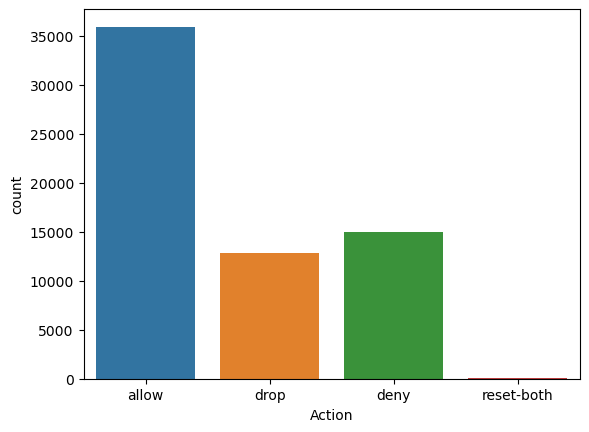

In [11]:
# bar plot for countof each action
sns.countplot(data=data, x = 'Action')

<Axes: >

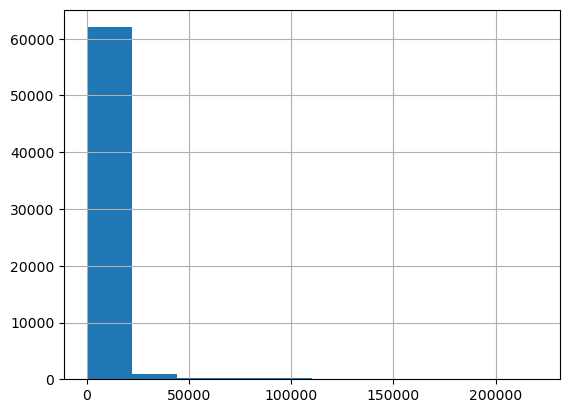

In [12]:
# Distribution of Bytes
data['Bytes'].hist()

<Axes: title={'center': 'Bytes'}, xlabel='Action'>

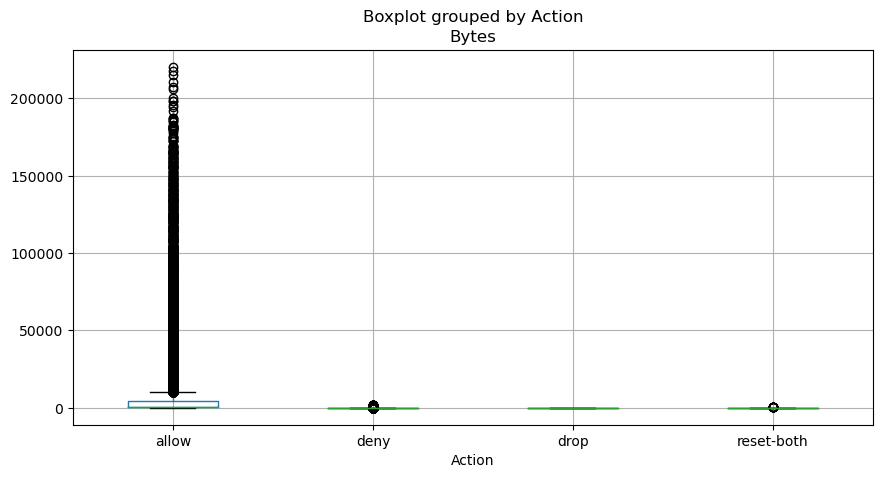

In [13]:
data.boxplot(column=['Bytes'], by='Action', figsize=(10,5))

<Axes: >

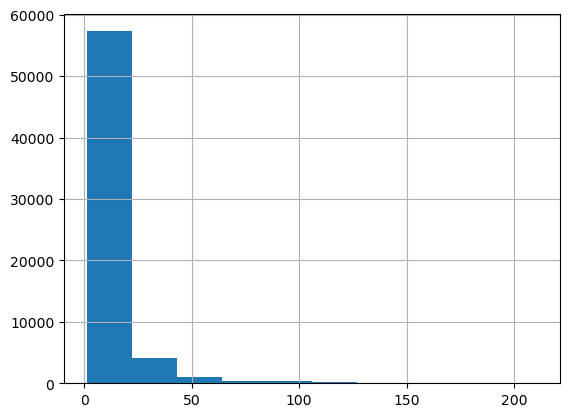

In [14]:
data['Packets'].hist()

<Axes: title={'center': 'Packets'}, xlabel='Action'>

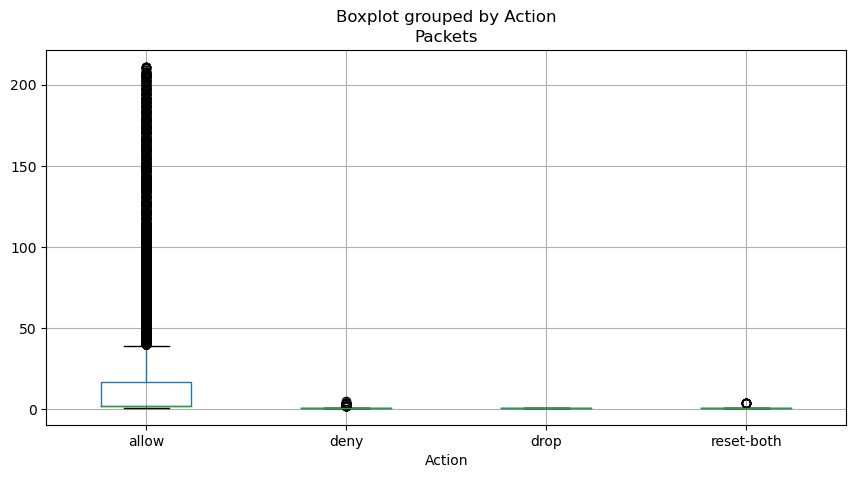

In [15]:
data.boxplot(column=['Packets'], by='Action', figsize=(10,5))

In [16]:
# mapping values from 'Action' column to numbers
data['Action'] =  data["Action"].map({'allow':1, 'deny':0, 'drop':2, 'reset-both':3})

<Axes: >

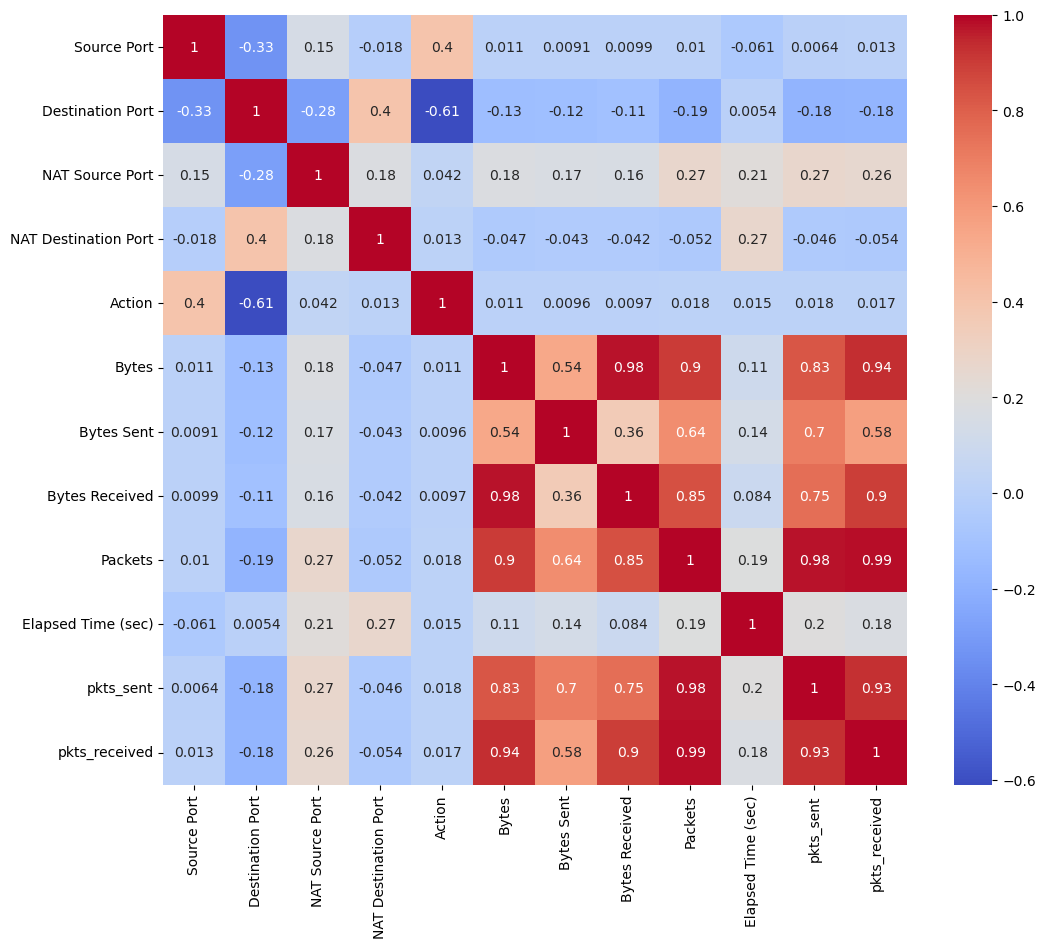

In [17]:
# plotting a heatmap of the correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(),cmap='coolwarm', annot=True)

## Feature Engineering

The dataset we are using has recorded port numbers on private devices as well as port numbers translated by NAT. Hence we can create two features for source and destination based on information if Port Translation (NAT) was required while passing the traffic. The features Source Port Translation and Destination Port Translation can be encoded by 1 if port numbers on devices and NAT are different indicating the requirement of NAT. Otherwise, they will be encoded by 0 indicating no translation was required.

In [18]:
# adding translation features
data['Source Port Translation'] = (data['Source Port'] != data['NAT Source Port']).astype('int')
data['Destination Port Translation'] = (data['Destination Port'] != data['NAT Destination Port']).astype('int')

In [19]:
# building bidirectional graph by using port numbers on host devices
HOST_NW = nx.DiGraph(name = "Host")
HOST_NW.add_edges_from(data[['Source Port', 'Destination Port']].values)
joblib.dump(HOST_NW, 'host_nw.pkl')
# building bidirectional graph by using port numbers on NAT 
NAT_NW = nx.DiGraph(name = "NAT")
NAT_NW.add_edges_from(data[['NAT Source Port', 'NAT Destination Port']].values)
joblib.dump(NAT_NW, 'nat_nw.pkl')

['nat_nw.pkl']

In [20]:
def common_ports(nw, src, dst):
    """
    Counts no. of common ports connected directly between src and dst ports.
    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port
    Returns:
        No. of common ports from intersection of set of neighbors of both src and dst ports
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst))))
    except:
        return 0

In [21]:
# # adding features to the dataset
data['Host CP'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT CP'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

In [22]:
def jaccard_index(nw, src, dst):
    """
    Counts Jaccard index between src and dst ports.
    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port
    Returns:
        Jaccard Index
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))) / len(set(nw.neighbors(src)).union(set(nw.neighbors(dst))))
    except:
        return 0

In [23]:
data['Host JI'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT JI'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

In [24]:
def salton_index(nw, src, dst):
    """
    Counts Salton index between src and dst ports.
    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port
    Returns:
        Salton Index
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))) / np.sqrt(len(set(nw.neighbors(src))) * len(set(nw.neighbors(dst))))
    except:
        return 0

In [25]:
data['Host SL'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT SL'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

In [26]:
def sorensen_index(nw, src, dst):
    """
    Counts Sorensen index between src and dst ports.
    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port
    Returns:
        Sorensen Index
    """
    try:
        return len(set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))) / (len(set(nw.neighbors(src))) + len(set(nw.neighbors(dst))))
    except:
        return 0

In [27]:
data['Host SI'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT SI'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

In [28]:
def adamic_adar_index(nw, src, dst):
    """
    Counts Adamic-Adar index between src and dst ports.
    Args:
        nw: Network instance
        src: Source Port
        dst: Destination Port
    Returns:
        Adamic-Adar Index
    """
    try:
        ports = set(nw.neighbors(src)).intersection(set(nw.neighbors(dst)))
        return 1/np.sum([np.log10(set(nw.neighbors(port))) for port in ports])
    except:
        return 0

In [29]:
data['Host AA'] = data.apply(lambda row: common_ports(HOST_NW, row['Source Port'], row['Destination Port']), axis = 1)
data['NAT AA'] = data.apply(lambda row: common_ports(NAT_NW, row['NAT Source Port'], row['NAT Destination Port']), axis = 1)

In [30]:
host_page_rank = nx.pagerank(HOST_NW)
nat_page_rank = nx.pagerank(NAT_NW)

In [31]:
data['Host Source PR'] = data.apply(lambda row: host_page_rank.get(row['Source Port'], 0), axis = 1)
data['Host Destination PR'] = data.apply(lambda row: host_page_rank.get(row['Destination Port'], 0), axis = 1)
data['NAT Source PR'] = data.apply(lambda row: nat_page_rank.get(row['NAT Source Port'], 0), axis = 1)
data['NAT Destination PR'] = data.apply(lambda row: nat_page_rank.get(row['NAT Destination Port'], 0), axis = 1)

In [32]:
y = data['Action']
X = data.drop(['Action'], axis = 1)

In [33]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 859)

In [34]:
robust_scaler = RobustScaler()
robust_scaler_features = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'Host Source PR', 'Host Destination PR', 'NAT Source PR', 'NAT Destination PR']
X_train_robust_scaled = robust_scaler.fit_transform(X_train[robust_scaler_features])
X_cv_robust_scaled = robust_scaler.transform(X_cv[robust_scaler_features])
joblib.dump(robust_scaler, 'robust_scaler.pkl')

['robust_scaler.pkl']

In [35]:
std_scaler = StandardScaler()
std_scaler_features = ['Host CP', 'NAT CP', 'Host JI', 'NAT JI', 'Host SL', 'NAT SL', 'Host SI', 'NAT SI', 'Host AA', 'NAT AA']
X_train_std_scaled = std_scaler.fit_transform(X_train[std_scaler_features])
X_cv_std_scaled = std_scaler.transform(X_cv[std_scaler_features])
joblib.dump(std_scaler, 'std_scaler.pkl')

['std_scaler.pkl']

In [36]:
X_train_preprocessed = np.hstack((X_train[X_train.columns[:4]], X_train_robust_scaled, X_train_std_scaled, X_train[['Source Port Translation', 'Destination Port Translation']]))
X_cv_preprocessed = np.hstack((X_cv[X_cv.columns[:4]], X_cv_robust_scaled, X_cv_std_scaled, X_cv[['Source Port Translation', 'Destination Port Translation']]))

# BaseLine Model

In [37]:
def baseline_model(feature_matrix, train_labels):
    """
    Generates random probabilities of output class proportional to their weights, where weights are no.of instances of that class divided by total no. 
    of instances in the train data
    Args:
        feature_matrix: Feature matrix of the dataset
        train_labels: Actual labels of the instances in the train data
    Returns:
        random class labels as predictions
    """
    classes = list(train_labels.unique())
    # classes = no.of unique classes
    class_weights = [np.sum(train_labels == i)/train_labels.shape[0] for i in train_labels.unique()]
    # class_weights = list of class weights computed from train data
    labels = np.random.choice(classes, size = feature_matrix.shape[0], p = class_weights)
    # labels = predicted labels by random sampling of class labels proportional to their weights in train data
    probs = np.zeros((labels.shape[0], len(classes)))
    # probs = matrix of predicted probabilities
    for i in range(labels.shape[0]):
        # generate probabilities by adding random numbers between 0 and 1 to predicted class labels which ensures it has highest probability among all classes
        probs[i] = classes.index(labels[i]) + np.random.random_sample(len(classes))
        # normalizing probabilities of all classes so that they add up to 1
        probs[i] /= np.sum(probs[i])
    # probs = normalized random probabilities of output classes
    return labels, probs

In [38]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap="Purples", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Log loss on Train Data using Random Model: 1.5373290326929314
Log loss on Test Data using Random Model: 1.5314067875478217


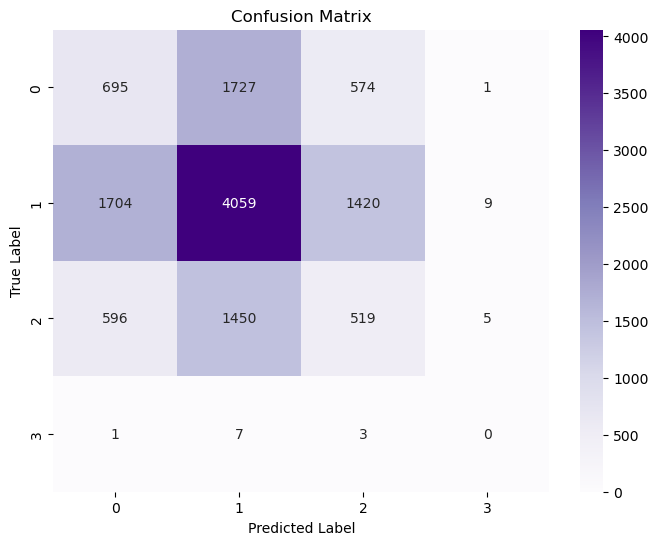

In [39]:
random_model_train_labels, random_model_train_probs = baseline_model(X_train, y_train)
random_model_test_labels, random_model_test_probs = baseline_model(X_cv, y_train)

random_model_train_loss = log_loss(y_train, random_model_train_probs, eps=1e-15)
print(f"Log loss on Train Data using Random Model: {random_model_train_loss}")
random_model_test_loss = log_loss(y_cv, random_model_test_probs, eps=1e-15)
print(f"Log loss on Test Data using Random Model: {random_model_test_loss}")
plot_confusion_matrix(y_cv, random_model_test_labels)

# RandomForest

In [40]:
rf = RandomForestClassifier(n_estimators = 2000, max_depth = 20, criterion = 'entropy', class_weight = 'balanced', n_jobs = -1, random_state = 859)
rf.fit(X_train_preprocessed, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, n_estimators=2000, n_jobs=-1,
                       random_state=859)

In [41]:
calibrator_rf = CalibratedClassifierCV(rf, method = 'isotonic', cv = 'prefit')
calibrator_rf.fit(X_cv_preprocessed, y_cv)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        criterion='entropy',
                                                        max_depth=20,
                                                        n_estimators=2000,
                                                        n_jobs=-1,
                                                        random_state=859),
                       method='isotonic')

In [42]:
y_train_probs_rf = calibrator_rf.predict_proba(X_train_preprocessed)
y_cv_probs_rf = calibrator_rf.predict_proba(X_cv_preprocessed)

In [43]:
def log_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = - np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

In [44]:
y_train_max_rf = np.amax(y_train_probs_rf, axis=1) #np.amax(y_train_probs, axis=1)
y_cv_max_rf = np.amax(y_cv_probs_rf, axis=1)

In [45]:
train_loss_rf = log_loss(y_train, y_train_max_rf)
cv_loss_rf = log_loss(y_cv, y_cv_max_rf)

In [46]:
y_pred_rf = calibrator_rf.predict(X_cv_preprocessed)
accuracy_score(y_cv, y_pred_rf)

0.9988253719655442

Log loss on Train Data using Support Vectors Model: 0.8683276635322249
Log loss on Validation Data using Support Vectors Model: 0.870788241648848


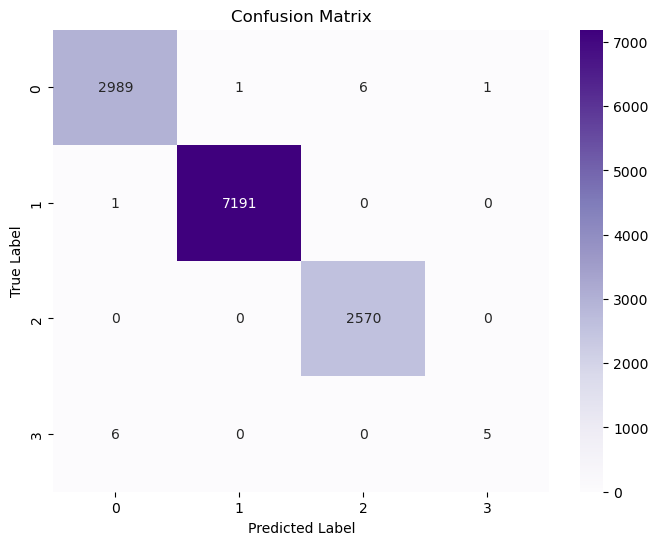

In [47]:
print(f"Log loss on Train Data using Support Vectors Model: {train_loss_rf}")
print(f"Log loss on Validation Data using Support Vectors Model: {cv_loss_rf}")
plot_confusion_matrix(y_cv, y_pred_rf)

In [48]:
pk.dump(calibrator_rf, open(r'calibrator_rf.pkl', 'wb'))

# LGBMclassifier

In [49]:
lgbm = LGBMClassifier(n_estimators = 750, max_depth = 4, objective = 'multiclass', class_weight = 'balanced', n_jobs = -1, random_state = 859)
lgbm.fit(X_train_preprocessed, y_train)

LGBMClassifier(class_weight='balanced', max_depth=4, n_estimators=750,
               objective='multiclass', random_state=859)

In [50]:
calibrator_lgbm = CalibratedClassifierCV(lgbm, method = 'isotonic', cv = 'prefit')
calibrator_lgbm.fit(X_cv_preprocessed, y_cv)

CalibratedClassifierCV(cv='prefit',
                       estimator=LGBMClassifier(class_weight='balanced',
                                                max_depth=4, n_estimators=750,
                                                objective='multiclass',
                                                random_state=859),
                       method='isotonic')

In [51]:
y_train_probs_lgbm = calibrator_lgbm.predict_proba(X_train_preprocessed)
y_cv_probs_lgbm = calibrator_lgbm.predict_proba(X_cv_preprocessed)

In [52]:
y_train_max_lgbm = np.amax(y_train_probs_lgbm, axis=1) #np.amax(y_train_probs, axis=1)
y_cv_max_lgbm = np.amax(y_cv_probs_lgbm, axis=1)

In [53]:
train_loss_lgbm = log_loss(y_train, y_train_max_lgbm)
cv_loss_lgbm = log_loss(y_cv, y_cv_max_lgbm)

In [54]:
y_pred_lgbm = calibrator_lgbm.predict(X_cv_preprocessed)
accuracy_score(y_cv, y_pred_lgbm)

0.998981989036805

Log loss on Train Data using Support Vectors Model: 2.4235095459729417
Log loss on Validation Data using Support Vectors Model: 2.3097962865916775


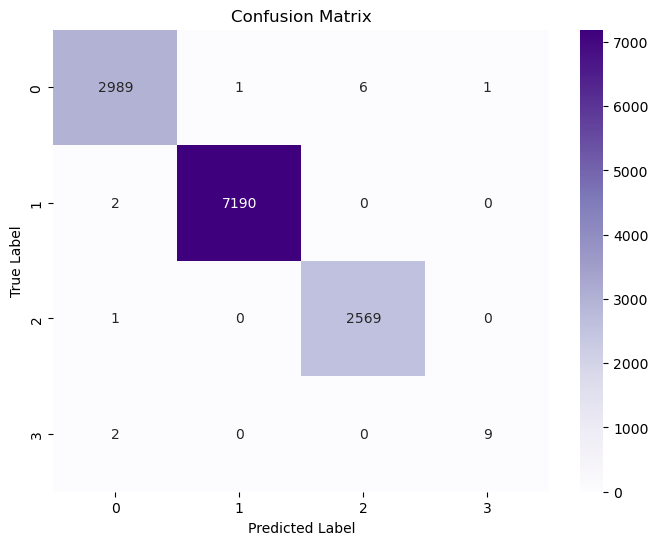

In [55]:
print(f"Log loss on Train Data using Support Vectors Model: {train_loss_lgbm}")
print(f"Log loss on Validation Data using Support Vectors Model: {cv_loss_lgbm}")
plot_confusion_matrix(y_cv, y_pred_lgbm)

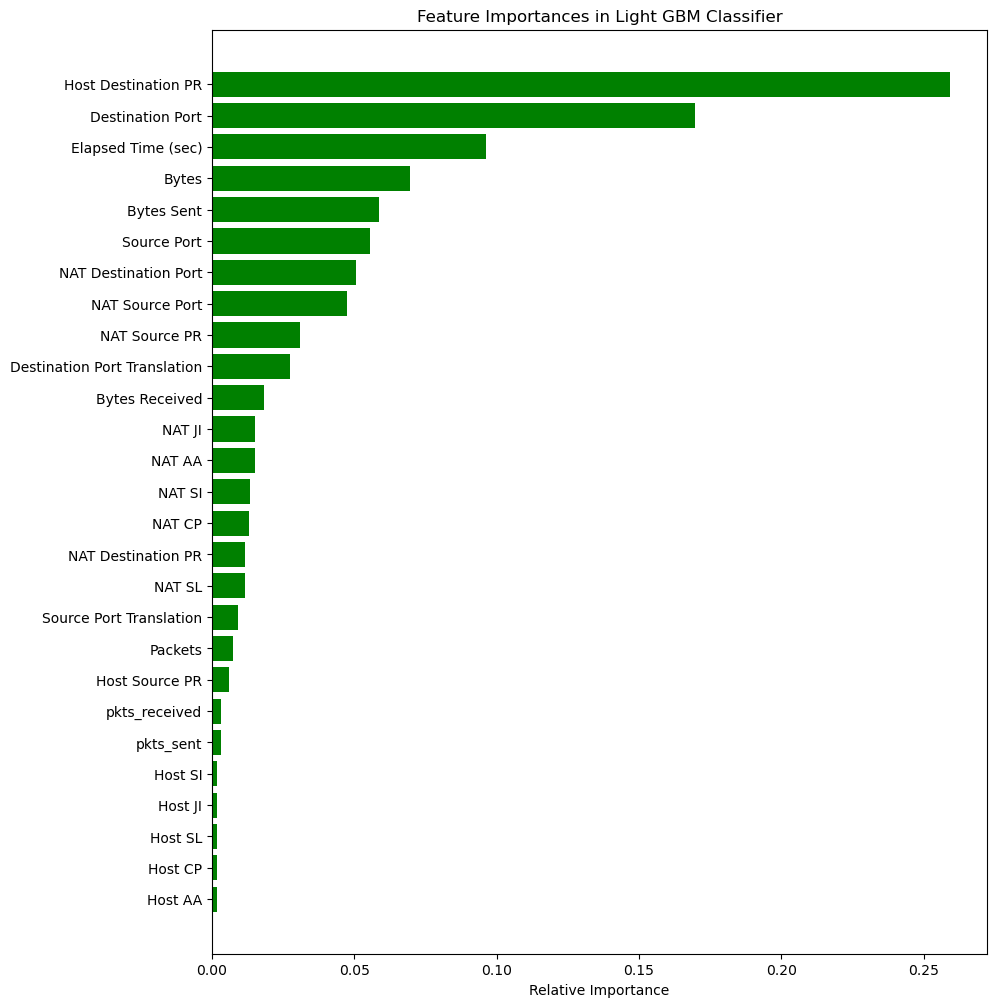

In [56]:
features = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port',
            'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
            'pkts_received', 'Host Source PR', 'Host Destination PR', 'NAT Source PR', 'NAT Destination PR',
            'Host CP', 'NAT CP', 'Host JI', 'NAT JI', 'Host SL', 'NAT SL', 'Host SI', 'NAT SI', 'Host AA',
            'NAT AA', 'Source Port Translation', 'Destination Port Translation']
# array of feature importances
importances = rf.feature_importances_
# sorting indices of importances in decreasing order
indices = (np.argsort(importances))
# plotting the horizontal barplot
plt.figure(figsize=(10,12))
plt.title('Feature Importances in Light GBM Classifier')
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [57]:
joblib.dump(calibrator_lgbm, 'calibrator_lgbm.pkl')

['calibrator_lgbm.pkl']

# Support Vector Classifier

In [58]:
svc = SVC(kernel='rbf', C=1.0, gamma='scale')
svc.fit(X_train_preprocessed, y_train)

SVC()

In [59]:
calibrator_svc = CalibratedClassifierCV(svc, method = 'isotonic', cv = 'prefit')
calibrator_svc.fit(X_cv_preprocessed, y_cv)

CalibratedClassifierCV(cv='prefit', estimator=SVC(), method='isotonic')

In [60]:
y_train_probs_svc = calibrator_svc.predict_proba(X_train_preprocessed)
y_cv_probs_svc = calibrator_svc.predict_proba(X_cv_preprocessed)

In [61]:
y_train_max_svc = np.amax(y_train_probs_svc, axis=1) #np.amax(y_train_probs, axis=1)
y_cv_max_svc = np.amax(y_cv_probs_svc, axis=1)

In [62]:
train_loss_svc = log_loss(y_train, y_train_max_svc)
cv_loss_svc = log_loss(y_cv, y_cv_max_svc)

In [63]:
y_pred_svc = calibrator_svc.predict(X_cv_preprocessed)
accuracy_score(y_cv, y_pred_svc)

0.9847298355520752

Log loss on Train Data using Support Vectors Model: 0.8633431305737557
Log loss on Validation Data using Support Vectors Model: 0.9485624541387968


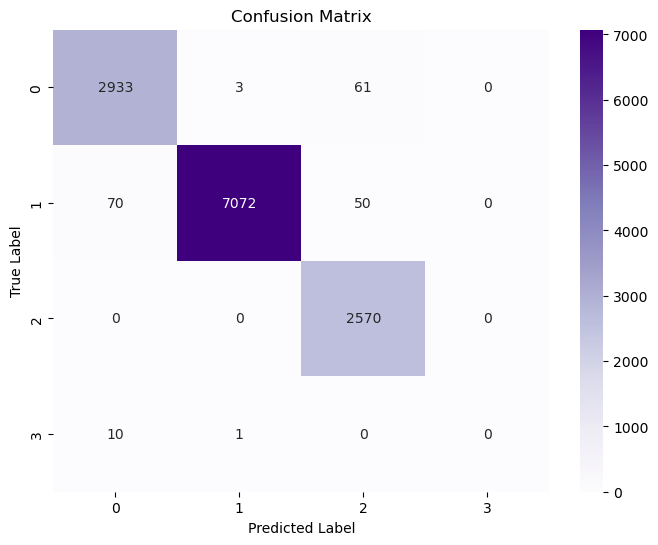

In [64]:
print(f"Log loss on Train Data using Support Vectors Model: {train_loss_svc}")
print(f"Log loss on Validation Data using Support Vectors Model: {cv_loss_svc}")
plot_confusion_matrix(y_cv, y_pred_svc)

In [65]:
pk.dump(calibrator_svc, open(r'calibrator_svc.pkl', 'wb'))

# LogisticRegression

In [66]:
logistic = LogisticRegression(C = 1, penalty = 'l2', class_weight = 'balanced', n_jobs = -1, random_state = 859)
logistic.fit(X_train_preprocessed, y_train)

LogisticRegression(C=1, class_weight='balanced', n_jobs=-1, random_state=859)

In [67]:
calibrator_logistic = CalibratedClassifierCV(logistic, method = 'isotonic', cv = 'prefit')
calibrator_logistic.fit(X_cv_preprocessed, y_cv)

CalibratedClassifierCV(cv='prefit',
                       estimator=LogisticRegression(C=1,
                                                    class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=859),
                       method='isotonic')

In [68]:
y_train_probs_log = calibrator_logistic.predict_proba(X_train_preprocessed)
y_cv_probs_log = calibrator_logistic.predict_proba(X_cv_preprocessed)

In [69]:
y_train_max_log = np.amax(y_train_probs_log, axis=1) #np.amax(y_train_probs, axis=1)
y_cv_max_log = np.amax(y_cv_probs_log, axis=1)

In [70]:
train_loss_log = log_loss(y_train, y_train_max_log)
cv_loss_log = log_loss(y_cv, y_cv_max_log)

In [71]:
y_pred_log = calibrator_logistic.predict(X_cv_preprocessed)
accuracy_score(y_cv, y_pred_log)

0.9846515270164448

Log loss on Train Data using Logistic Regression Model: 0.1326837804045058
Log loss on Validation Data using Logistic Regression Model: 0.13232761384490072


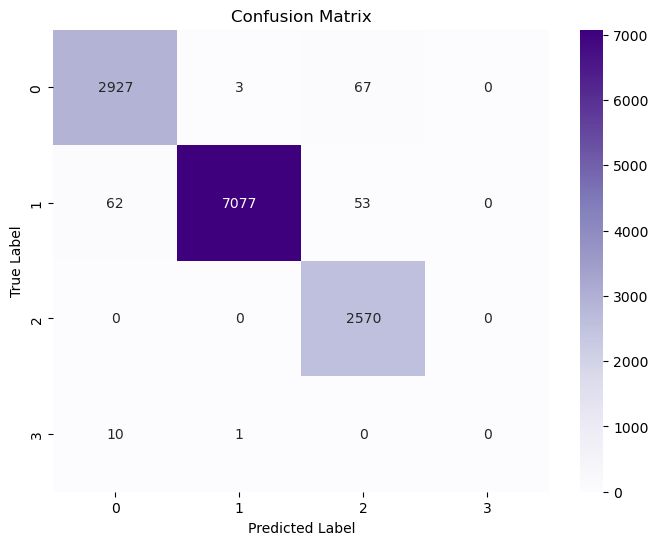

In [72]:
print(f"Log loss on Train Data using Logistic Regression Model: {train_loss_log}")
print(f"Log loss on Validation Data using Logistic Regression Model: {cv_loss_log}")
plot_confusion_matrix(y_cv, y_pred_log)

# KNN

In [73]:
knn = KNeighborsClassifier(n_neighbors = 8, weights = 'distance')
knn.fit(X_train_preprocessed, y_train)

KNeighborsClassifier(n_neighbors=8, weights='distance')

In [74]:
calibrator_knn = CalibratedClassifierCV(knn, method = 'isotonic', cv = 'prefit')
calibrator_knn.fit(X_cv_preprocessed, y_cv)

CalibratedClassifierCV(cv='prefit',
                       estimator=KNeighborsClassifier(n_neighbors=8,
                                                      weights='distance'),
                       method='isotonic')

In [75]:
y_train_probs_knn = calibrator_knn.predict_proba(X_train_preprocessed)
y_cv_probs_knn = calibrator_knn.predict_proba(X_cv_preprocessed)

In [76]:
y_train_max_knn = np.amax(y_train_probs_knn, axis=1) #np.amax(y_train_probs, axis=1)
y_cv_max_knn = np.amax(y_cv_probs_knn, axis=1)

In [77]:
train_loss_knn = log_loss(y_train, y_train_max_knn)
cv_loss_knn = log_loss(y_cv, y_cv_max_knn)

In [78]:
y_pred_knn = calibrator_knn.predict(X_cv_preprocessed)
accuracy_score(y_cv, y_pred_knn)

0.9929522317932654

knn loss on Train Data using knnistic Regression Model: 0.2283415654453475
knn loss on Validation Data using knnistic Regression Model: 0.21701026779005228


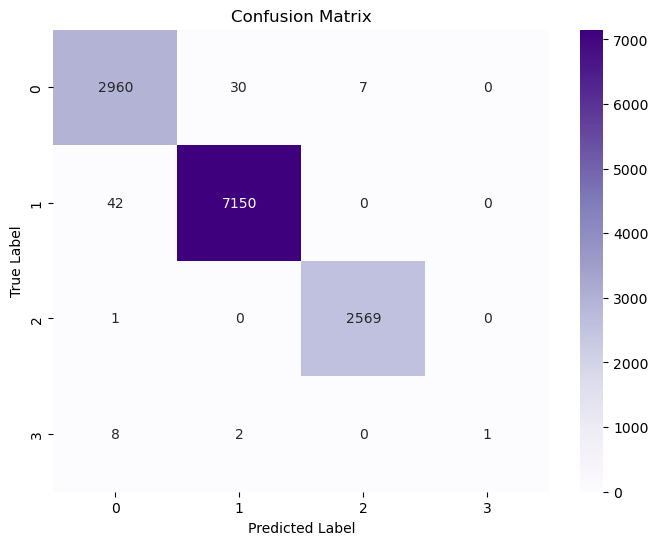

In [79]:
print(f"knn loss on Train Data using knnistic Regression Model: {train_loss_knn}")
print(f"knn loss on Validation Data using knnistic Regression Model: {cv_loss_knn}")
plot_confusion_matrix(y_cv, y_pred_knn)

# Model Summary

In [80]:
import time
def check(model, vector):
    """
    Checks the run-time complexity of the model for a single log data. Gives mean of 100 test runs for reliability
    Args:
        model: Instance of the ML model
        vector: vector of log data
    Returns:
        Mean run time of prediction
    """
    times = []
    for i in range(100):
        t = time.time()
        pred = model.predict(vector)
        times.append(time.time() - t)
    return np.round(np.mean(times), 4)

In [81]:
elapsed_times= {}
Xc = X_cv.iloc[0].to_numpy()
elapsed_times['KNeighbors Classifier'] = check(calibrator_knn, Xc.reshape(1, -1))
elapsed_times['Logistic Regression'] = check(calibrator_logistic, Xc.reshape(1, -1))
elapsed_times['Support Vectors'] = check(calibrator_svc, Xc.reshape(1, -1))
elapsed_times['Random Forest Classifier'] = check(calibrator_rf, Xc.reshape(1, -1))
elapsed_times['Light GBM Classifier'] = check(calibrator_lgbm, Xc.reshape(1, -1))

In [82]:
elapsed_times

{'KNeighbors Classifier': 0.0352,
 'Logistic Regression': 0.0011,
 'Support Vectors': 0.0019,
 'Random Forest Classifier': 0.2731,
 'Light GBM Classifier': 0.0015}

In [93]:
# Importing python libraries :
import pandas as pd
print("pandas :",pd.__version__)
import numpy as np
print("numpy :",np.__version__)
import seaborn as sns
print("seaborn :",sns.__version__)
from lightgbm import LGBMClassifier
# print(LGBMClassifier.__version__())
import sklearn
print("sklearn :",sklearn.__version__)
from sklearn.metrics import log_loss, confusion_matrix
# print('The scikit-learn version is {}.'.format(scikit-learn.__version__))
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import networkx as nx
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# import matplotlib.pyplot as plt
# print('matplotlib: {}'.format(plt.__version__))
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pickle as pk

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

pandas : 1.5.3
numpy : 1.23.5
seaborn : 0.12.2
sklearn : 1.2.2
matplotlib: 3.7.1
